In [40]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# warnings Ignore
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import cross_val_score

# sklearn Models
from sklearn.neural_network import MLPRegressor

# ploting Styles
from matplotlib import rcParams
plt.style.use('seaborn-talk')

In [5]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 19
plt.rc('figure', figsize=(6,5))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

### Import data

In [6]:
data = pd.read_csv('activity_post_showrand.csv')

In [7]:
data.describe()

,price,avg_likes,avg_comments,followers
count,1.893000e+03,1893.000000,1893.000000,1.893000e+03
mean,3.593165e+05,5309.831326,339.677073,3.076290e+05
std,1.880650e+06,16022.712518,7171.583360,4.846184e+05
min,2.200000e+03,2.000000,0.000000,1.500000e+01
25%,5.500000e+04,610.700000,13.900000,7.021000e+04
50%,1.100000e+05,1578.900000,38.000000,1.664750e+05
75%,2.200000e+05,4556.100000,107.300000,3.422160e+05
max,6.050000e+07,384564.200000,309455.000000,6.192507e+06


In [8]:
# drop very large outlier
data.drop(data[data['avg_comments']==max(data['avg_comments'])].index, inplace=True)

In [9]:
# log of price column
data['price'] = data['price'].apply(lambda x: np.log10(x))

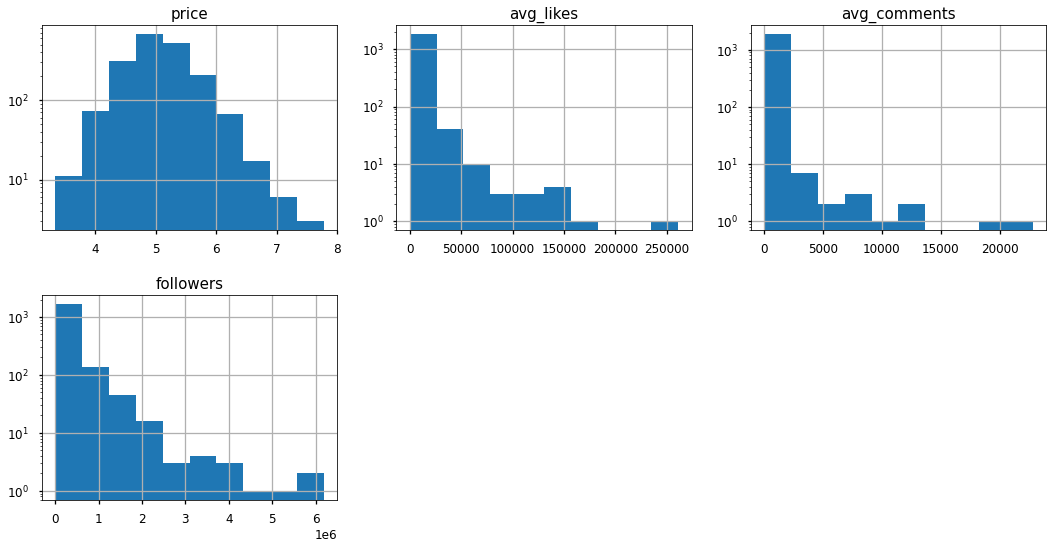

In [10]:
data.hist(layout=(2,3),figsize=(15,8),log=True)
plt.tight_layout()
plt.show()

In [48]:
X = data[['followers','avg_likes', 'avg_comments']].values
Y = data['price'].values

## Max Abs
ma = MaxAbsScaler().fit(X) # Best results
X = ma.transform(X)


## Qunatile
# trans = QuantileTransformer(n_quantiles=100)
# X = trans.fit_transform(X)

## Standard
# s_scaler = StandardScaler().fit(X)
# X = s_scaler.transform(X)


tst_size = 0.09
ns, nf = np.shape(X) 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X_train :',len(X_train),'   X_test :',len(X_test))

X_train : 1721    X_test : 171


## Optimizing the model

### Validaion curve

[1.00000000e-06 2.06913808e-06 4.28133240e-06 8.85866790e-06
 1.83298071e-05 3.79269019e-05 7.84759970e-05 1.62377674e-04
 3.35981829e-04 6.95192796e-04 1.43844989e-03 2.97635144e-03
 6.15848211e-03 1.27427499e-02 2.63665090e-02 5.45559478e-02
 1.12883789e-01 2.33572147e-01 4.83293024e-01 1.00000000e+00]


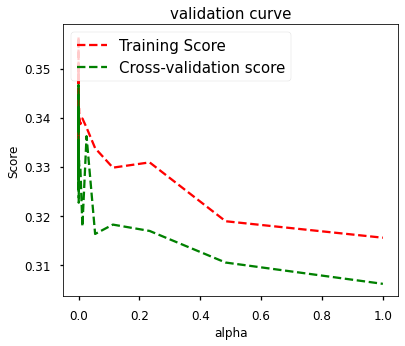

Best alpha: 1.8329807108324375e-05


In [13]:
model = MLPRegressor(max_iter=1000)

param_range = np.logspace(-6,0, 20)
param_name = 'alpha'
print(param_range)

scoring = 'r2'
cv =5

train_scores, test_scores = validation_curve(
model, X=X_train, y=Y_train, cv=cv, param_name=param_name, param_range=param_range,
scoring=scoring, n_jobs=1)


train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,'r--',label = 'Training Score')
plt.plot(param_range, test_scores_mean,'g--',label = 'Cross-validation score')

plt.title('validation curve')
plt.xlabel(param_name)
plt.ylabel('Score')
plt.legend(loc='upper left')

plt.show()
print(f'Best {param_name}: {param_range[np.argmax(test_scores_mean)]}')

### Grid search

In [20]:
from sklearn.model_selection import GridSearchCV

grid = {
     'hidden_layer_sizes': [(50,3),(80,3),(100,3),(100,4),(100,5),(200,4),(200,5)],
}

In [ ]:
mlpr = MLPRegressor(max_iter=1000, batch_size=238, alpha=18e-5, solver='lbfgs', learning_rate='adaptive', activation='relu')
mlpr_grid = GridSearchCV(mlpr ,param_grid= grid, scoring='r2', cv=4
                         , pre_dispatch=2, return_train_score=True, verbose=2)
mlpr_grid.fit(X_train , Y_train)

In [25]:
pd.DataFrame(mlpr_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.438643,0.585397,0.000749,0.000432,"(50, 3)","{'hidden_layer_sizes': (50, 3)}",0.374081,0.472100,-0.024539,-0.001230,0.205103,0.220879,7,0.478226,4.173306e-01,-1.332268e-15,-2.886580e-15,0.223889,0.224922
1,1.393531,1.648810,0.000520,0.000520,"(80, 3)","{'hidden_layer_sizes': (80, 3)}",0.370576,0.435838,0.423346,-0.001232,0.307132,0.179711,6,0.474933,3.785586e-01,4.423836e-01,-6.446133e-10,0.323969,0.190229
2,2.677836,1.590739,0.001021,0.000015,"(100, 3)","{'hidden_layer_sizes': (100, 3)}",0.370272,0.477665,0.400964,-0.001230,0.311918,0.184979,4,0.474788,4.431607e-01,4.555804e-01,-1.110223e-15,0.343382,0.198572
3,1.719990,1.442950,0.001018,0.000021,"(100, 4)","{'hidden_layer_sizes': (100, 4)}",0.367596,-0.004832,0.436256,0.431364,0.307596,0.182403,5,0.472205,-2.220446e-16,4.390511e-01,4.650697e-01,0.344082,0.199038
4,2.158603,1.191695,0.000997,0.000691,"(100, 5)","{'hidden_layer_sizes': (100, 5)}",0.363614,0.476422,0.424664,0.418531,0.420808,0.039950,2,0.474924,4.406856e-01,4.299881e-01,4.492836e-01,0.448720,0.016601
5,5.636472,2.302604,0.001286,0.000429,"(200, 4)","{'hidden_layer_sizes': (200, 4)}",0.383664,0.491610,0.388021,0.435766,0.424765,0.043671,1,0.484171,4.361821e-01,4.187594e-01,4.672083e-01,0.451580,0.025597
6,3.967329,2.826832,0.001475,0.000498,"(200, 5)","{'hidden_layer_sizes': (200, 5)}",0.369450,0.494353,0.418956,-0.001231,0.320382,0.190936,3,0.472802,4.483621e-01,4.428157e-01,-2.586011e-10,0.340995,0.197196


In [22]:
print(f'The best score of the combinations: {mlpr_grid.best_score_:.4}')
print(f'The best parameters found by grid search: {mlpr_grid.best_params_}')

The best score of the combinations: 0.4248
The best parameters found by grid search: {'hidden_layer_sizes': (200, 4)}


## Learning Curve

E:\Users\ff15m\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


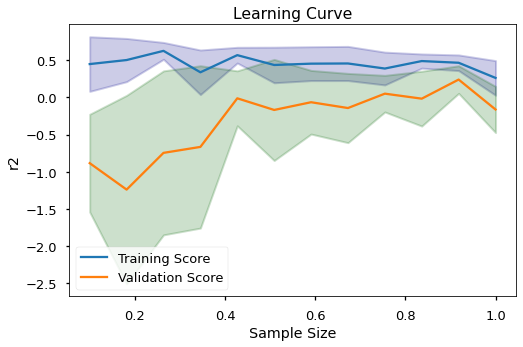

Training scores:

                cv1           cv2           cv3       cv4           cv5
151  -1.598721e-14 -3.335110e-13  7.310935e-01  0.777514  7.408048e-01
275   3.496534e-01  7.150967e-01 -8.881784e-16  0.733382  7.224116e-01
398   4.074766e-01  6.594661e-01  6.470339e-01  0.709005  7.157077e-01
522   3.576100e-01  7.027980e-01  0.000000e+00  0.635266 -1.776357e-15
646   3.656458e-01  6.732638e-01  5.992500e-01  0.608681  6.030972e-01
770   3.591602e-01  6.211334e-01  6.172978e-01  0.589997 -3.108624e-15
894  -1.115189e-09  5.592589e-01  5.714374e-01  0.573390  5.729533e-01
1017 -2.434407e-06  5.477742e-01  5.477233e-01  0.587684  6.061811e-01
1141  2.873458e-01  5.389554e-01  5.488899e-01  0.000000  5.735475e-01
1265  3.034490e-01  5.294230e-01  5.152722e-01  0.573004  5.305867e-01
1389  2.594517e-01  5.090567e-01  5.082077e-01  0.554081  5.066035e-01
1513  2.769433e-01 -1.776357e-15  5.072372e-01  0.533169  0.000000e+00

 --------------------------------------------------------

In [71]:
train_sizes = np.linspace(0.1,1,12)
model = MLPRegressor(max_iter=2000, hidden_layer_sizes=(200,4), batch_size=238, alpha=18e-5
                     ,activation='relu', learning_rate='adaptive', solver='lbfgs')

cv=5
scoring= 'r2'

ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= model , X = X,
                                                   y = Y, train_sizes = train_sizes, cv = cv, random_state = 0)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  validation_scores.mean(axis = 1)
validation_scores_std  = validation_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns_list) )
print('\n', '-' * 70) # separator to make the output easy to read
valid_df = pd.DataFrame(validation_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns_list)
valid_df['mean_score'] = validation_scores_mean
print('\nValidation scores:\n\n',valid_df )

## Final model and prediction

In [146]:
# Best split
# trn_size = (valid_df[valid_df['mean_score']==max(valid_df['mean_score'])].index[0])
# trn_size= 1388
# ns, nf = np.shape(X) 
# X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=40) , random_state=42, train_size =trn_size )
# print('X_train :',len(X_train),'   X_test :',len(X_test))

df = data.sample(frac=1,random_state=15)
# X_train = s_scaler.transform(df[['followers','avg_likes','avg_comments']].iloc[:1388].values)
X_train = ma.transform(df[['followers','avg_likes','avg_comments']].iloc[:1388].values)
Y_train = df['price'].iloc[:1388].values

# Final model
final_mlp = MLPRegressor(max_iter=2000, hidden_layer_sizes=(200,4), batch_size=238, alpha=2e-5
                        ,activation='relu', learning_rate='adaptive', solver='lbfgs',random_state=10)
final_mlp.fit(X_train, Y_train)

MLPRegressor(alpha=2e-05, batch_size=238, hidden_layer_sizes=(200, 4),
             learning_rate='adaptive', max_iter=2000, random_state=10,
             solver='lbfgs')

In [3]:
# Save the model

# from pickle import dump,load
## save the classifier
# with open('mlp_all_post_showrand.pkl', 'wb') as fid:
#     dump(final_mlp, fid)    

## load it again
# with open('mlp_all_post_showrand.pkl', 'rb') as fid:
#     final_mlp = load(fid)

In [162]:
# X_test = s_scaler.transform(df.iloc[1388:][['followers','avg_likes','avg_comments']].values)
X_test = ma.transform(df.iloc[1388:][['followers','avg_likes','avg_comments']].values)
Y_test = df.iloc[1388:]['price'].values
print(f'The R2 score of the model is : {final_mlp.score(X_test, Y_test):.4f}')

The R2 score of the model is : 0.5066


In [163]:
## prediction

prices = np.power(10,Y_test)
predicted = np.power(10,final_mlp.predict(X_test))
print(f'The MAE of the model is: {np.mean(np.abs(prices-predicted)):.2f}')

print(f'Actual price:    {np.round(prices[60:70],0)}')
print(f'Predicted price: {np.round(predicted[60:70],0)}')

The MAE of the model is: 172184.17
Actual price:    [143000.  88000. 220000. 121000.  30800. 275000.  55000.  55000. 473000.
 110000.]
Predicted price: [ 98671.  81165. 118381.  54258.  52935. 146206.  59666.  74195. 325224.
  98915.]


In [164]:
l = len(Y_test)
prices_class=np.zeros(l,dtype=int)
predicted_class=np.zeros(l,dtype=int)

divider = np.array([20,30,50,100,150,200,400,500,800,1000,1500,3000])

for d in 1000*divider:
    prices_class += (prices>d).astype('int32')
    predicted_class += (predicted>d).astype('int32')

print(f'MAE: {np.mean(np.abs(prices_class-predicted_class)):.4f}')
print(f'Actual price:    {prices_class[:15]}')
print(f'Predicted price: {predicted_class[:15]}')

MAE: 1.2599
Actual price:    [4 6 6 5 3 4 2 3 3 3 3 5 4 3 4]
Predicted price: [4 4 3 6 5 8 4 5 3 3 6 4 3 3 4]


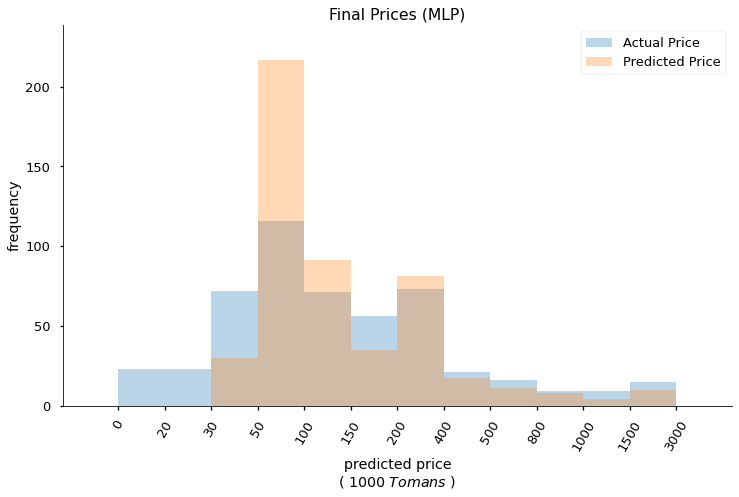

In [165]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, xlabel='predicted price\n( 1000 $Tomans$ )', ylabel='frequency', title='Final Prices (MLP)')
plt.xticks(ticks=range(max(prices_class)+1), labels=np.insert(divider,0,0),rotation=60)
ax.hist(prices_class, bins=max(prices_class), alpha=0.3, label='Actual Price')
ax.hist(predicted_class, bins=max(predicted_class-2), alpha=0.3, label='Predicted Price')
plt.legend(loc=0)
plt.margins(0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Save Figure
# plt.savefig('Final Prices MLP.png',bbox_inches='tight', pad_inches=0.4, facecolor='w')

plt.show()

In [166]:
## Text Output is in final_output array
divider_0 = np.insert(divider,0,0)
final_output= np.zeros(len(predicted_class),dtype=object)
orig_price = np.zeros(len(prices_class),dtype=object)
for i in range(len(predicted_class)):
    if predicted_class[i] <= len(divider_0)-2:
        final_output[i]= f'{divider_0[predicted_class[i]]} - {divider_0[predicted_class[i]+1]}'
    else:
        final_output[i] = f'> {divider_0[predicted_class[i]]}'
    
for i in range(len(prices_class)):
    if prices_class[i] <= len(divider_0)-2:
        orig_price[i]= f'{divider_0[prices_class[i]]} - {divider_0[prices_class[i]+1]}'
    else:
        orig_price[i] = f'> {divider_0[prices_class[i]]}'

In [167]:
print(final_output[:10])
print(predicted_class[:10])

['100 - 150' '100 - 150' '50 - 100' '200 - 400' '150 - 200' '500 - 800'
 '100 - 150' '150 - 200' '50 - 100' '50 - 100']
[4 4 3 6 5 8 4 5 3 3]


In [168]:
print(orig_price[310:320])
print(prices_class[310:320])
print(prices[310:320])

['800 - 1000' '200 - 400' '200 - 400' '100 - 150' '50 - 100' '50 - 100'
 '1000 - 1500' '150 - 200' '800 - 1000' '100 - 150']
[ 9  6  6  4  3  3 10  5  9  4]
[ 935000.  385000.  253000.  110000.   99000.   66000. 1100000.  187000.
  997500.  110000.]


In [169]:
df_test = df.iloc[1388:]
df_test

,username,price,avg_likes,avg_comments,followers
1072,zibaie.mag,5.120574,1176.0,176.2,136786
387,one_word_per_day,5.546543,1600.0,18.9,357268
1494,arzha_net,5.342423,914.7,14.5,50134
606,Moshavereh_steve,5.271842,9468.6,137.2,333258
1060,khoda_txt,4.740363,5297.2,164.4,176328
...,...,...,...,...,...
157,tvfactt,5.439333,4359.9,110.4,747711
385,Shadi_yani,5.217484,1990.2,8.4,377195
646,majaleye_ashpazi_khob,5.120574,499.1,28.0,230788
1782,ferdowsi_uni,4.995635,492.9,7.7,17748


In [170]:
df_test = df_test.assign(predicted=final_output,price=orig_price)
df_test = df_test[['username','avg_likes','avg_comments','followers','price','predicted']]

In [171]:
df_test

,username,avg_likes,avg_comments,followers,price,predicted
1072,zibaie.mag,1176.0,176.2,136786,100 - 150,100 - 150
387,one_word_per_day,1600.0,18.9,357268,200 - 400,100 - 150
1494,arzha_net,914.7,14.5,50134,200 - 400,50 - 100
606,Moshavereh_steve,9468.6,137.2,333258,150 - 200,200 - 400
1060,khoda_txt,5297.2,164.4,176328,50 - 100,150 - 200
...,...,...,...,...,...,...
157,tvfactt,4359.9,110.4,747711,200 - 400,200 - 400
385,Shadi_yani,1990.2,8.4,377195,150 - 200,100 - 150
646,majaleye_ashpazi_khob,499.1,28.0,230788,100 - 150,50 - 100
1782,ferdowsi_uni,492.9,7.7,17748,50 - 100,50 - 100


In [172]:
df_test.to_csv('post_test_showrand.csv',index=False)